In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Set the path to your dataset
dataset_dir = ""

# Set the input size for resizing the images
input_size = (128,128)

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

In [4]:
# Load the training dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the test dataset
test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Set device (CPU or GPU)
device = torch.device("cpu")

In [6]:
num_epochs = 20
num_classes = len(train_dataset.classes)

# Load the pre-trained EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)

# Move the model to the device
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\Alvin/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:48<00:00, 443kB/s]


Loaded pretrained weights for efficientnet-b0


In [7]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training loop

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate average train loss for the epoch
    train_loss /= len(train_loader)

    # Print the train loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")


Epoch [1/20], Train Loss: 0.7456
Epoch [2/20], Train Loss: 0.2459
Epoch [3/20], Train Loss: 0.1486
Epoch [4/20], Train Loss: 0.1088
Epoch [5/20], Train Loss: 0.0633
Epoch [6/20], Train Loss: 0.0276
Epoch [7/20], Train Loss: 0.0720
Epoch [8/20], Train Loss: 0.0493
Epoch [9/20], Train Loss: 0.0260
Epoch [10/20], Train Loss: 0.0416
Epoch [11/20], Train Loss: 0.0940
Epoch [12/20], Train Loss: 0.0579
Epoch [13/20], Train Loss: 0.0349
Epoch [14/20], Train Loss: 0.0157
Epoch [15/20], Train Loss: 0.0029
Epoch [16/20], Train Loss: 0.0062
Epoch [17/20], Train Loss: 0.0075
Epoch [18/20], Train Loss: 0.0209
Epoch [19/20], Train Loss: 0.1053
Epoch [20/20], Train Loss: 0.0270


In [9]:
# Uncomment below lines to save model
# # Path for the saved model
path = './models/efficientnet.pt'
# Comment out below line if you have already saved model and just want to retrieve it (not saving)
torch.save(model.state_dict(), path)

In [10]:
# Testing loop
model.load_state_dict(torch.load(path))
model.eval()
test_correct = 0

preds_tensor = torch.Tensor()
labels_tensor = torch.Tensor()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        preds_tensor = torch.cat((preds_tensor, predicted))
        labels_tensor = torch.cat((labels_tensor, labels))
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = test_correct / len(test_dataset)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


Final Test Accuracy: 0.9563


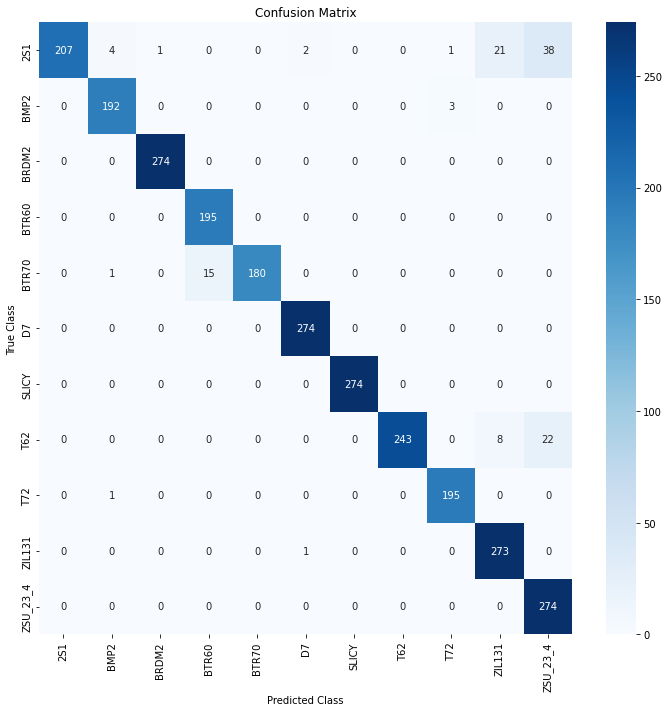

In [11]:
preds = preds_tensor.numpy()
actual = labels_tensor.numpy()

# Define the mapping dictionary
class_mapping = {
    0: '2S1',
    1: 'BMP2',
    2: 'BRDM2',
    3: 'BTR60',
    4: 'BTR70',
    5: 'D7',
    6: 'SLICY',
    7: 'T62',
    8: 'T72',
    9: 'ZIL131',
    10: 'ZSU_23_4'
}

y_preds = np.array([class_mapping[value] for value in preds])
y_true = np.array([class_mapping[value] for value in actual])

class_labels = ['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70',
                'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_preds, labels=class_labels)

# Set figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Configure figure properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()

# Show the figure
plt.show()


In [12]:
class_wise_accuracies = np.diag(cm) / cm.sum(axis=1)

# Display the class-wise accuracies
for i, accuracy in enumerate(class_wise_accuracies):
    label = class_labels[i]
    print(f'Accuracy of class {label}: {accuracy:.2%}')


Accuracy of class 2S1: 75.55%
Accuracy of class BMP2: 98.46%
Accuracy of class BRDM2: 100.00%
Accuracy of class BTR60: 100.00%
Accuracy of class BTR70: 91.84%
Accuracy of class D7: 100.00%
Accuracy of class SLICY: 100.00%
Accuracy of class T62: 89.01%
Accuracy of class T72: 99.49%
Accuracy of class ZIL131: 99.64%
Accuracy of class ZSU_23_4: 100.00%
